# Yelp Sentiment Analysis

## 1) Reading the Data

In [3]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

df = pd.read_csv('yelp.csv')
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


## 2) Adjusting the Data

In [4]:
#Clean the text (example: eating -> eat)
def text_cleaner(txt):
    txt = re.sub(r'[^\w\s]', '', txt) #remove punctuation (stack overflow)
    txt = txt.lower() #make lowercase
    words = txt.split() #split into words

    lemmatizer = WordNetLemmatizer() #geeksforgeeks
    stop_words = set(stopwords.words('english'))
    cleaned_words = []
    for word in words:
        if word not in stop_words:
            x = lemmatizer.lemmatize(word)  #cleans the words
            cleaned_words.append(x)
            
    cleaned_txt = ' '.join(cleaned_words) #turn back into sentence
    return cleaned_txt

df['cleaned_text'] = df['text'].apply(text_cleaner) #cleans the text column and adds it to new column


In [5]:
print("Original Text vs Cleaned Text\n")
print(df[['text', 'cleaned_text']].head())

Original Text vs Cleaned Text

                                                text  \
0  My wife took me here on my birthday for breakf...   
1  I have no idea why some people give bad review...   
2  love the gyro plate. Rice is so good and I als...   
3  Rosie, Dakota, and I LOVE Chaparral Dog Park!!...   
4  General Manager Scott Petello is a good egg!!!...   

                                        cleaned_text  
0  wife took birthday breakfast excellent weather...  
1  idea people give bad review place go show plea...  
2  love gyro plate rice good also dig candy selec...  
3  rosie dakota love chaparral dog park convenien...  
4  general manager scott petello good egg go deta...  


## 3) Converting Data Into Vectors

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

#turning words into vectors
vectorizer = TfidfVectorizer(
    max_df=0.6,         #If a term appears in more than 60% of the documents, ignore it.
    min_df=10,           #If a term appears in less than 10 documents, ignore it.
    max_features=8000,  #Top 8000 most frequent terms are kept.
    ngram_range=(1, 3), #Considers single words and 2,3-word combinations. (ngram (1,2) gave lower accuracy for naive bayes)
    stop_words='english' #Removes words like "and" , "the"
)

X = vectorizer.fit_transform(df['cleaned_text']).toarray()
# 4 or 5 star ratings will be considered positive (1)
# 1,2,3 star ratings will be considered negative (0)
y = df['stars'].apply(lambda x: 1 if x > 3 else 0)


In [19]:
print("\nBinary Target Variable 'y'\n")
print(y.sample(10))


Binary Target Variable 'y'

2575    0
7106    1
8678    1
3607    1
2927    0
7591    1
5691    1
6455    1
2971    1
3382    1
Name: stars, dtype: int64


## 4) Splitting the Data

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4) #split the data


## 5) Models

### a) Naive Bayes

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)
print("Naive Bayes Model Evaluation\n")
print(classification_report(y_test, y_pred_nb))

print("Confusion Matrix for Multinomial Naive Bayes:")
print(confusion_matrix(y_test,y_pred_nb))

Naive Bayes Model Evaluation

              precision    recall  f1-score   support

           0       0.91      0.37      0.52       917
           1       0.78      0.98      0.87      2083

    accuracy                           0.79      3000
   macro avg       0.84      0.67      0.69      3000
weighted avg       0.82      0.79      0.76      3000

Confusion Matrix for Multinomial Naive Bayes:
[[ 335  582]
 [  35 2048]]


### b) Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=150) #max iterations to converge
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Model Evaluation\n")
print(classification_report(y_test, y_pred_lr))

print("Confusion Matrix for Logistic Regression:")
print(confusion_matrix(y_test,y_pred_lr))

Logistic Regression Model Evaluation

              precision    recall  f1-score   support

           0       0.84      0.58      0.69       917
           1       0.84      0.95      0.89      2083

    accuracy                           0.84      3000
   macro avg       0.84      0.77      0.79      3000
weighted avg       0.84      0.84      0.83      3000

Confusion Matrix for Logistic Regression:
[[ 534  383]
 [  98 1985]]


### c) SVM

In [24]:
from sklearn.svm import SVC

svm_model = SVC() #support vector classifier
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)
print("SVM Model Evaluation\n")
print(classification_report(y_test, y_pred_svm))

print("Confusion Matrix for Support Vector Machine:")
print(confusion_matrix(y_test,y_pred_svm))

SVM Model Evaluation

              precision    recall  f1-score   support

           0       0.85      0.58      0.69       917
           1       0.84      0.95      0.89      2083

    accuracy                           0.84      3000
   macro avg       0.84      0.77      0.79      3000
weighted avg       0.84      0.84      0.83      3000

Confusion Matrix for Support Vector Machine:
[[ 534  383]
 [  97 1986]]


### d) Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=4)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
print("Random Forest Model Evaluation\n")
print(classification_report(y_test, y_pred_rf))

print("Confusion Matrix for Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Model Evaluation

              precision    recall  f1-score   support

           0       0.82      0.49      0.61       917
           1       0.81      0.95      0.88      2083

    accuracy                           0.81      3000
   macro avg       0.81      0.72      0.75      3000
weighted avg       0.81      0.81      0.80      3000

Confusion Matrix for Random Forest:
[[ 452  465]
 [ 101 1982]]


### e) Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=4)
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)
print("Decision Tree Model Evaluation\n")
print(classification_report(y_test, y_pred_dt))

print("Confusion Matrix for Decision Tree:")
print(confusion_matrix(y_test, y_pred_dt))


Decision Tree Model Evaluation

              precision    recall  f1-score   support

           0       0.53      0.55      0.54       917
           1       0.80      0.78      0.79      2083

    accuracy                           0.71      3000
   macro avg       0.66      0.67      0.66      3000
weighted avg       0.71      0.71      0.71      3000

Confusion Matrix for Decision Tree:
[[ 506  411]
 [ 457 1626]]


## 6) Accuracy Comparison

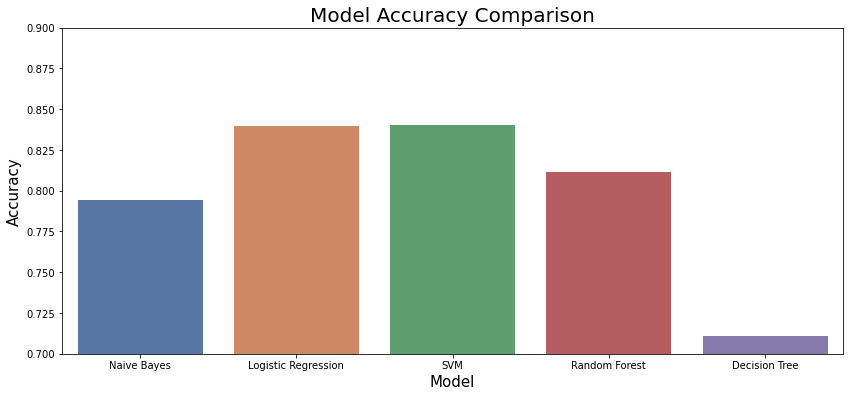

In [27]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

#compare the accuracies
accuracy_nb = accuracy_score(y_test, y_pred_nb)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_dt = accuracy_score(y_test, y_pred_dt)

accuracies = [accuracy_nb, accuracy_lr, accuracy_svm, accuracy_rf, accuracy_dt]
model_names = ['Naive Bayes', 'Logistic Regression', 'SVM', 'Random Forest', 'Decision Tree']

plt.figure(figsize=(14, 6))
sns.barplot(x=model_names, y=accuracies, palette="deep")
plt.ylim(0.7, 0.9)
plt.title('Model Accuracy Comparison',fontsize=20)
plt.xlabel('Model',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.show()


## 7) Confusion Matrices

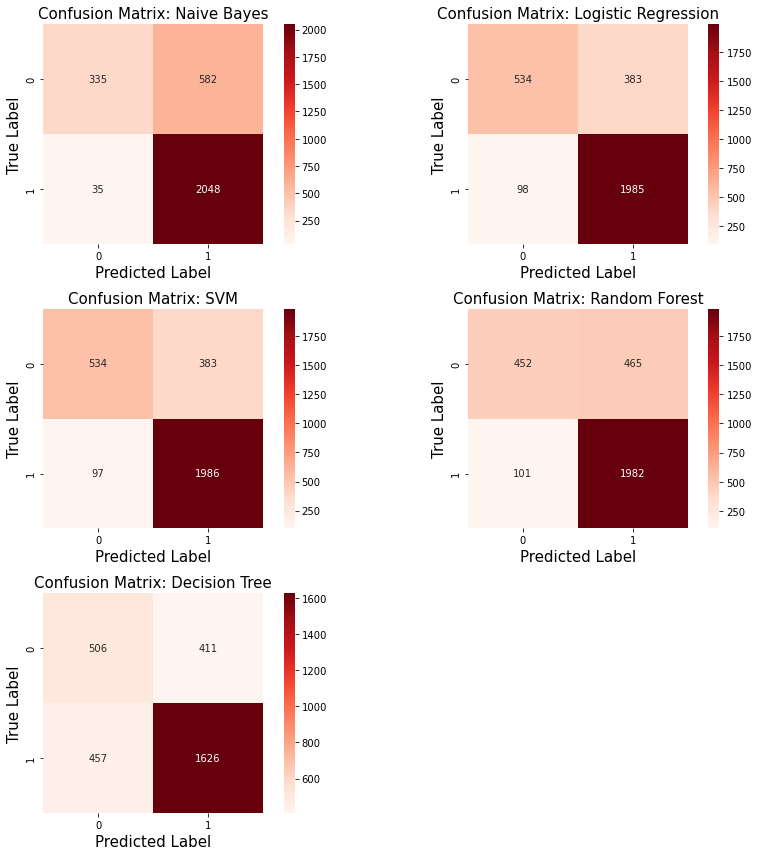

In [28]:
from sklearn.metrics import confusion_matrix

#compare confusion matrices
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

confusion_matrices = [conf_matrix_nb, conf_matrix_lr, conf_matrix_svm, conf_matrix_rf, conf_matrix_dt] 
model_names = ['Naive Bayes', 'Logistic Regression', 'SVM', 'Random Forest', 'Decision Tree']

fig, axes = plt.subplots(3, 2, figsize=(12, 12))  

axes = axes.flatten()

for i, model in enumerate(model_names):
    sns.heatmap(confusion_matrices[i], annot=True, fmt='d', cmap='Reds', square=True, ax=axes[i]) #generate heatmaps (geeksforgeeks)
    axes[i].set_title(f'Confusion Matrix: {model}',fontsize=15)
    axes[i].set_xlabel('Predicted Label',fontsize=15)
    axes[i].set_ylabel('True Label',fontsize=15)

axes[-1].axis('off') #hide last subplot

plt.tight_layout()
plt.show()

## 8) F1 Score Comparison

In [29]:
y.value_counts() #unbalanced data, better to compare using F1 score

1    6863
0    3137
Name: stars, dtype: int64

In [84]:
#comparing models according to F1 scores
report_nb = classification_report(y_test, y_pred_nb, output_dict=True)
report_lr = classification_report(y_test, y_pred_lr, output_dict=True)
report_svm = classification_report(y_test, y_pred_svm, output_dict=True)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
report_dt = classification_report(y_test, y_pred_dt, output_dict=True)

models = ['Naive Bayes', 'Logistic Regression', 'SVM', 'Random Forest', 'Decision Tree']

#create tables for class 0 and class 1
table_0 = pd.DataFrame({
    'Model': models,
    'Precision': [report_nb['0']['precision'], report_lr['0']['precision'], report_svm['0']['precision'], report_rf['0']['precision'], report_dt['0']['precision']],
    'Recall': [report_nb['0']['recall'], report_lr['0']['recall'], report_svm['0']['recall'], report_rf['0']['recall'], report_dt['0']['recall']],
    'F1-Score': [report_nb['0']['f1-score'], report_lr['0']['f1-score'], report_svm['0']['f1-score'], report_rf['0']['f1-score'], report_dt['0']['f1-score']]
})

table_1 = pd.DataFrame({
    'Model': models,
    'Precision': [report_nb['1']['precision'], report_lr['1']['precision'], report_svm['1']['precision'], report_rf['1']['precision'], report_dt['1']['precision']],
    'Recall': [report_nb['1']['recall'], report_lr['1']['recall'], report_svm['1']['recall'], report_rf['1']['recall'], report_dt['1']['recall']],
    'F1-Score': [report_nb['1']['f1-score'], report_lr['1']['f1-score'], report_svm['1']['f1-score'], report_rf['1']['f1-score'], report_dt['1']['f1-score']]
})

table_0_sorted= table_0.sort_values(by='F1-Score', ascending=False)
table_1_sorted= table_1.sort_values(by='F1-Score', ascending=False)

print("Class 0 (Negative Class) Comparison:")
print(table_0_sorted)
print("\nClass 1 (Positive Class) Comparison:")
print(table_1_sorted)



Class 0 (Negative Class) Comparison:
                 Model  Precision    Recall  F1-Score
2                  SVM   0.846276  0.582334  0.689922
1  Logistic Regression   0.844937  0.582334  0.689477
3        Random Forest   0.817360  0.492912  0.614966
4        Decision Tree   0.525441  0.551799  0.538298
0          Naive Bayes   0.905405  0.365322  0.520591

Class 1 (Positive Class) Comparison:
                 Model  Precision    Recall  F1-Score
2                  SVM   0.838328  0.953433  0.892183
1  Logistic Regression   0.838260  0.952952  0.891934
3        Random Forest   0.809971  0.951512  0.875055
0          Naive Bayes   0.778707  0.983197  0.869086
4        Decision Tree   0.798233  0.780605  0.789320


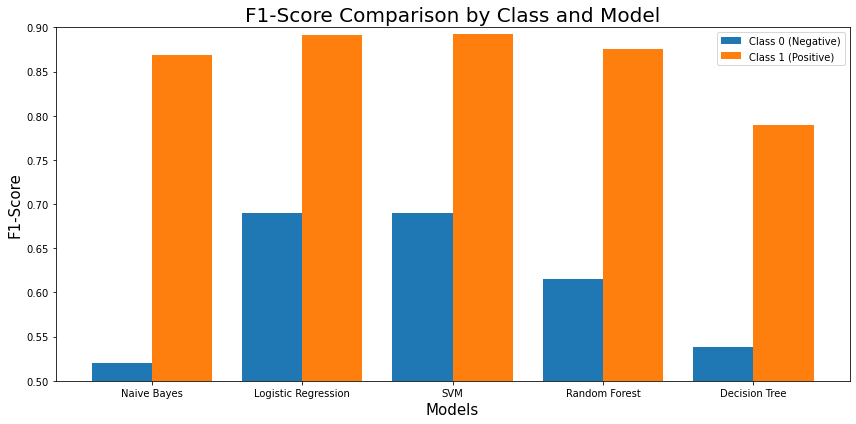

In [85]:
f1_scores_class_0 = table_0['F1-Score'].tolist()
f1_scores_class_1 = table_1['F1-Score'].tolist()
#making a 2 bar plot
nb= len(models)
index= np.arange(nb)
bar_width = 0.4

plt.figure(figsize=(12, 6))
bar1 = plt.bar(index, f1_scores_class_0, bar_width, label='Class 0 (Negative)') #from geeksforgeeks
bar2 = plt.bar(index + bar_width, f1_scores_class_1, bar_width, label='Class 1 (Positive)')

plt.xlabel('Models',fontsize=15)
plt.ylabel('F1-Score',fontsize=15)
plt.title('F1-Score Comparison by Class and Model',fontsize=20)
plt.xticks(index + bar_width / 2, models)
plt.legend()
plt.ylim(0.5, 0.9)
plt.tight_layout()
plt.show()


## 9) Prediction

### a) SVM

In [65]:
pd.set_option('display.max_colwidth', 54)
comparison_svm = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_svm})
comparison_svm = comparison_svm.join(df['text'].reset_index(drop=True))

print('SVM Prediction:\n')
print(comparison_svm.sample(15,random_state=17))


SVM Prediction:

      Actual  Predicted                                                   text
6895       0          1  This Dunkin Donuts is hit or miss.\n\nWhen i run i...
2536       1          1  This place is so good! I have eaten almost everyth...
6646       0          1  Slices Pizza is pretty good, not the best though. ...
2516       1          1  I totally agree with L.C.'s review.  Going to XCP ...
1919       0          0                                           D-scust-ing.
6795       1          1  Dr. Dairiki is terrific. She is professional, list...
6713       0          0  The worse food and service. I have never given a b...
188        1          1  Screw Disneyland- Sephora is the happiest place on...
328        0          0  I like the review of the whacked waiter... i think...
4739       0          0  I have been to Kyoto about 3-4 times in the past 7...
4212       1          1  Relatively inexpensive, good solid mexican food pl...
5511       1          1  today was 

### b) Logistic Regression

In [64]:
pd.set_option('display.max_colwidth', 54)
comparison_lr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_lr})
comparison_lr = comparison_lr.join(df['text'].reset_index(drop=True))

print('Logistic Regression Prediction:\n')
print(comparison_lr.sample(15,random_state=17))


Logistic Regression Prediction:

      Actual  Predicted                                                   text
6895       0          1  This Dunkin Donuts is hit or miss.\n\nWhen i run i...
2536       1          1  This place is so good! I have eaten almost everyth...
6646       0          1  Slices Pizza is pretty good, not the best though. ...
2516       1          1  I totally agree with L.C.'s review.  Going to XCP ...
1919       0          1                                           D-scust-ing.
6795       1          1  Dr. Dairiki is terrific. She is professional, list...
6713       0          0  The worse food and service. I have never given a b...
188        1          1  Screw Disneyland- Sephora is the happiest place on...
328        0          0  I like the review of the whacked waiter... i think...
4739       0          0  I have been to Kyoto about 3-4 times in the past 7...
4212       1          1  Relatively inexpensive, good solid mexican food pl...
5511       1       